<a href="https://colab.research.google.com/github/oyaon/Machine-Learning-Using-Python/blob/main/Dengue_Prediction_Dataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("Dhaka20-24.csv", parse_dates=["Date"])

# Filter data for 2020–2023 to compute monthly averages
historical = df[df["Date"].dt.year < 2024]
monthly_avg = historical.groupby(historical["Date"].dt.month)["Humidity"].mean()
monthly_std = historical.groupby(historical["Date"].dt.month)["Humidity"].std()

# Generate 2024 humidity data
df_2024 = df[df["Date"].dt.year == 2024].copy()

for index, row in df_2024.iterrows():
    month = row["Date"].month
    # Generate random humidity with historical mean ± std
    synthetic_humidity = np.random.normal(monthly_avg[month], monthly_std[month])
    # Clip values to realistic range (e.g., 40–100%)
    synthetic_humidity = np.clip(synthetic_humidity, 40, 100)
    df_2024.at[index, "Humidity"] = round(synthetic_humidity, 1)

# Update the original dataset
df.update(df_2024)
df.to_csv("Dhaka20-24_filled.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm

# Load dataset
df = pd.read_csv("Dhaka20-24.csv", parse_dates=["Date"])

# Set seed for reproducibility
np.random.seed(42)

# Split data into historical (2020-2023) and 2024
historical = df[df["Date"].dt.year < 2024]
df_2024 = df[df["Date"].dt.year == 2024].copy()

# Calculate monthly stats for humidity, rainfall, and temperature
monthly_stats = historical.groupby(historical["Date"].dt.month).agg(
    Humidity_mean=("Humidity", "mean"),
    Humidity_std=("Humidity", "std"),
    Rainfall_mean=("Rainfall", "mean"),
    Temp_mean=("Max_Temp", "mean")
).reset_index()

# Merge stats into 2024 data
df_2024["Month"] = df_2024["Date"].dt.month
df_2024 = df_2024.merge(monthly_stats, left_on="Month", right_on="Date")

# Generate truncated normal distribution (0-100% humidity)
def truncated_normal(mean, std, low=0, high=100, size=1):
    a = (low - mean) / std
    b = (high - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=size)

# Adjust humidity based on rainfall and temperature
df_2024["Humidity_adj"] = np.where(
    df_2024["Rainfall"] > 20,
    df_2024["Humidity_mean"] + 10,  # Increase humidity if heavy rain
    np.where(
        df_2024["Max_Temp"] > 35,
        df_2024["Humidity_mean"] - 5,  # Decrease humidity during heatwaves
        df_2024["Humidity_mean"]
    )
)

# Generate synthetic humidity
df_2024["Humidity"] = truncated_normal(
    mean=df_2024["Humidity_adj"],
    std=df_2024["Humidity_std"],
    size=len(df_2024)
).round(1)

# Clip to ensure no overshoot (safety check)
df_2024["Humidity"] = df_2024["Humidity"].clip(0, 100)

# Update original dataframe
df.update(df_2024[["Date", "Humidity"]])
df.to_csv("Dhaka20-24_refined.csv", index=False)

KeyError: "['Date'] not in index"

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm

# ... (Your existing code) ...


# Update original dataframe
# Set 'Date' as index for both DataFrames before updating
df = df.set_index('Date')
df_2024 = df_2024.set_index('Date_x')  # Use 'Date_x' as it's the original date column in df_2024

# Update with aligned indices
df.update(df_2024[["Humidity"]])  # Only update 'Humidity'

# Reset index to original state if needed
df = df.reset_index()

df.to_csv("Dhaka20-24_refined.csv", index=False)

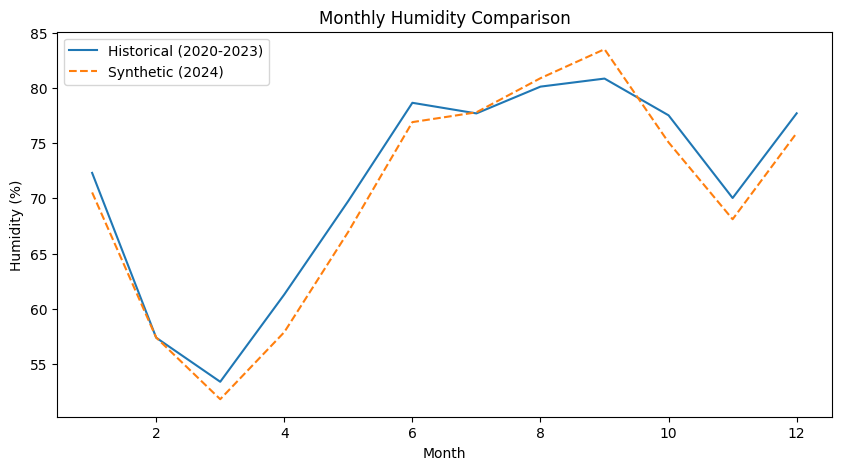

In [ ]:
import matplotlib.pyplot as plt

# Monthly averages comparison
plt.figure(figsize=(10, 5))
historical_monthly = historical.groupby(historical["Date"].dt.month)["Humidity"].mean()
df_2024_monthly = df_2024.groupby("Month")["Humidity"].mean()

plt.plot(historical_monthly.index, historical_monthly, label="Historical (2020-2023)")
plt.plot(df_2024_monthly.index, df_2024_monthly, label="Synthetic (2024)", linestyle="--")
plt.title("Monthly Humidity Comparison")
plt.xlabel("Month")
plt.ylabel("Humidity (%)")
plt.legend()
plt.show()

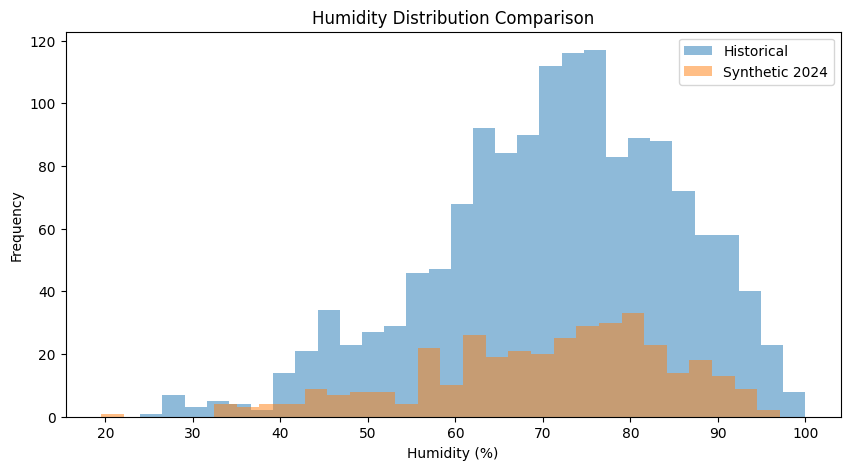

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(historical["Humidity"], bins=30, alpha=0.5, label="Historical")
plt.hist(df_2024["Humidity"], bins=30, alpha=0.5, label="Synthetic 2024")
plt.title("Humidity Distribution Comparison")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

<Figure size 1000x500 with 0 Axes>

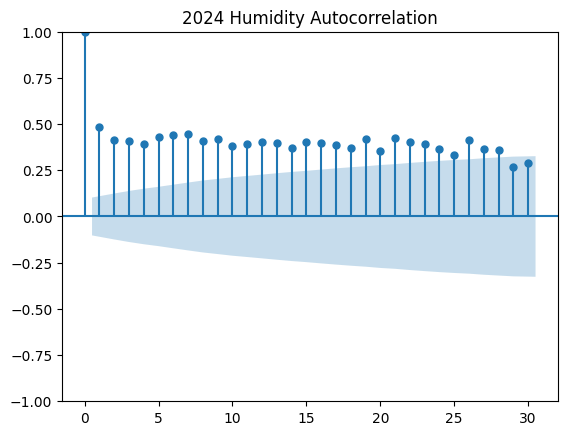

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 5))
plot_acf(df_2024["Humidity"], lags=30, title="2024 Humidity Autocorrelation")
plt.show()

In [ ]:
from scipy import stats

# Compare monthly means (2024 vs historical)
for month in range(1, 13):
    hist_data = historical[historical["Date"].dt.month == month]["Humidity"]
    synth_data = df_2024[df_2024["Month"] == month]["Humidity"]
    t_stat, p_val = stats.ttest_ind(hist_data, synth_data, nan_policy="omit")
    print(f"Month {month}: p-value = {p_val:.3f} ({'Same' if p_val > 0.05 else 'Different'})")

Month 1: p-value = 0.364 (Same)
Month 2: p-value = 0.995 (Same)
Month 3: p-value = 0.559 (Same)
Month 4: p-value = 0.214 (Same)
Month 5: p-value = 0.234 (Same)
Month 6: p-value = 0.303 (Same)
Month 7: p-value = 0.953 (Same)
Month 8: p-value = 0.608 (Same)
Month 9: p-value = 0.093 (Same)
Month 10: p-value = 0.261 (Same)
Month 11: p-value = 0.472 (Same)
Month 12: p-value = 0.439 (Same)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(historical["Humidity"], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
df_2024["Humidity"] = results.forecast(steps=len(df_2024))

In [ ]:
# Save to CSV (recommended for compatibility)
df.to_csv("Dhaka20-24_final.csv", index=False)

# Optional: Save to Excel
df.to_excel("Dhaka20-24_final.xlsx", index=False)

In [ ]:
# Display first 5 rows
print(df[df["Date"].dt.year == 2024][["Date", "Humidity"]].head())

# Display random 10 rows
print(df[df["Date"].dt.year == 2024].sample(10)[["Date", "Humidity"]])

           Date  Humidity
1461 2024-01-01      69.1
1462 2024-01-02      88.3
1463 2024-01-03      78.3
1464 2024-01-04      74.7
1465 2024-01-05      62.4
           Date  Humidity
1789 2024-11-24      67.2
1583 2024-05-02      59.4
1703 2024-08-30      90.2
1741 2024-10-07      90.1
1749 2024-10-15      71.1
1778 2024-11-13      57.7
1795 2024-11-30      48.0
1726 2024-09-22      85.6
1740 2024-10-06      86.0
1500 2024-02-09      55.8


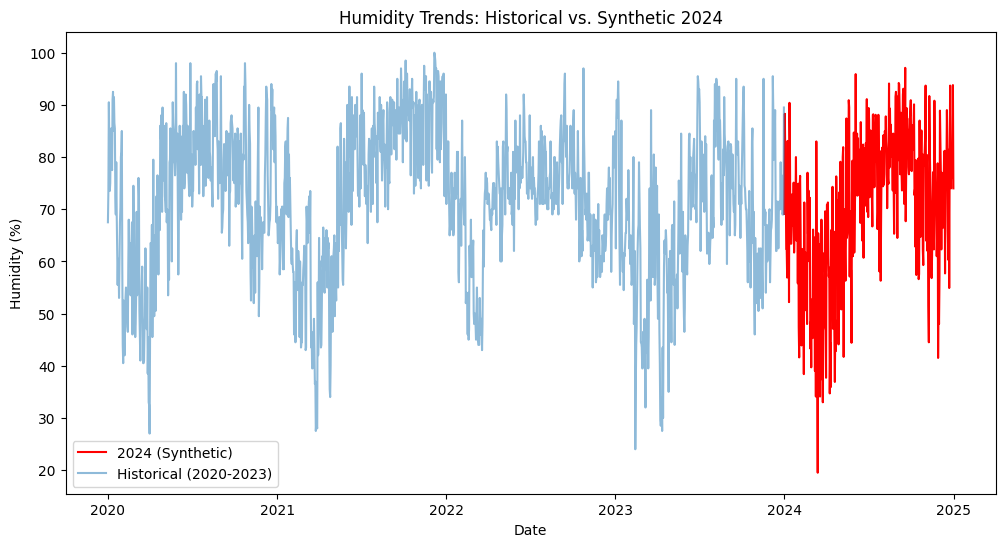

In [ ]:
import matplotlib.pyplot as plt

# Filter 2024 data
df_2024 = df[df["Date"].dt.year == 2024]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_2024["Date"], df_2024["Humidity"], label="2024 (Synthetic)", color="red")
plt.plot(historical["Date"], historical["Humidity"], label="Historical (2020-2023)", alpha=0.5)
plt.title("Humidity Trends: Historical vs. Synthetic 2024")
plt.xlabel("Date")
plt.ylabel("Humidity (%)")
plt.legend()
plt.show()

In [ ]:
print("2024 Humidity Stats:")
print(df_2024["Humidity"].describe())

print("\nHistorical Humidity Stats (2020-2023):")
print(historical["Humidity"].describe())

2024 Humidity Stats:
count    366.000000
mean      70.280874
std       14.174852
min       19.500000
25%       61.625000
50%       72.800000
75%       80.850000
max       97.100000
Name: Humidity, dtype: float64

Historical Humidity Stats (2020-2023):
count    1461.000000
mean       71.476044
std        13.923990
min        24.000000
25%        62.500000
50%        73.000000
75%        82.000000
max       100.000000
Name: Humidity, dtype: float64


# Backup Raw and Processed Data